In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = np.array((3.29,3.26,3.3,3.3,3.23,3.27,3.23,3.18,3.22,3.29,3.33,3.32,3.32,3.38,3.44,3.38,3.41,3.46,3.39,3.42,3.46,3.44,3.47,3.43,3.41,3.40,3.42,3.37
                 ,3.16,3.17,3.18,3.15,3.17,3.14,3.19,3.16,3.15,3.19,3.20,3.19))
df = pd.DataFrame(data, columns = ['Xbar'])
# Inspect the dataset
df.head()

,Xbar
0,3.29
1,3.26
2,3.30
3,3.30
4,3.23


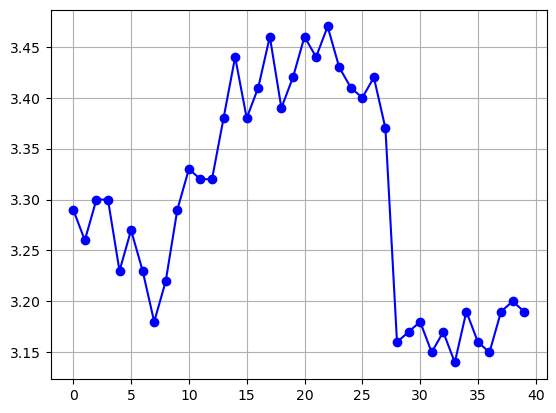

In [2]:
# Plot the data first
plt.plot(df, color='b', linestyle='-', marker='o')
plt.grid()
plt.show()

Runs test p-value = 0.000


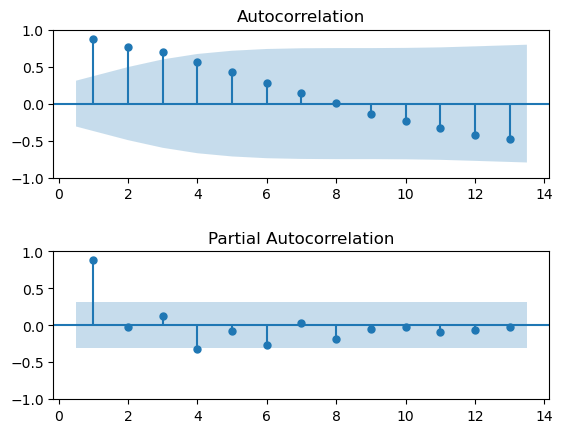

In [3]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df['Xbar'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df['Xbar'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df['Xbar'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()


In [4]:
df['lag1'] = df['Xbar'].shift(1)
df['operation']=np.arange(1,41,1)

# and split the dataset into regressors and target
X = df.iloc[1:, 1:]
y = df.iloc[1:, 0]

In [5]:
import qda
stepwise = qda.StepwiseRegression(add_constant = False, direction = 'both', alpha_to_enter = 0.15, alpha_to_remove = 0.15)

# Fit the model
model = stepwise.fit(y, X)

Stepwise Regression

######################################
### Step 1
-------------------
Forward Selection

COEFFICIENTS
------------
Term     Coef      P-Value
lag1 0.999119 1.725669e-70

MODEL SUMMARY
-------------
       S     R-sq  R-sq(adj)
0.051469 0.999763   0.999757

######################################
### Step 2
-------------------
Forward Selection

No predictor added. Exiting stepwise.
-------------------


In [6]:
results = model.model_fit
qda.summary(results)

REGRESSION EQUATION
-------------------
Xbar =  + 0.999 lag1

COEFFICIENTS
------------
Term   Coef  SE Coef  T-Value    P-Value
lag1 0.9991   0.0025 400.1923 1.7257e-70

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0515 0.9998     0.9998

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS     F-Value    P-Value
Regression  1.0 424.2815 424.2815 160153.9136 1.7257e-70
      lag1  1.0 424.2815 424.2815 160153.9136 1.7257e-70
     Error 38.0   0.1007   0.0026         NaN        NaN
     Total 39.0 424.3822      NaN         NaN        NaN


> Random Walk

Shapiro-Wilk test p-value = 0.170


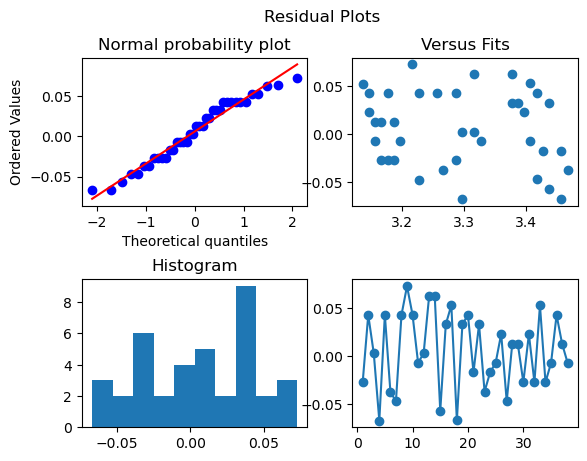

In [7]:
#Check on residuals
residuals = results.resid
residuals.pop(28)
fits = results.fittedvalues
fits.pop(28)
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the residuals
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

Runs test p-value on the residuals = 0.100


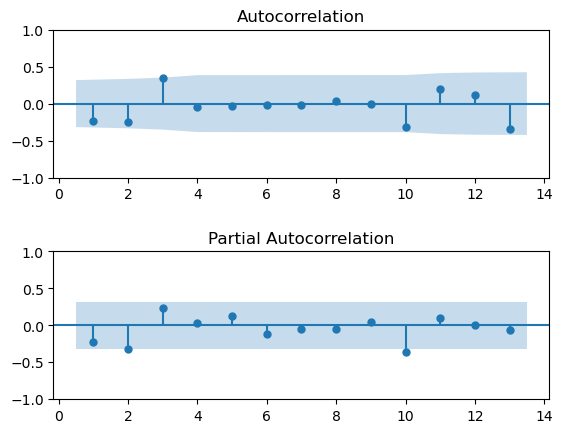

In [8]:
#RANDOMNESS OF FESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

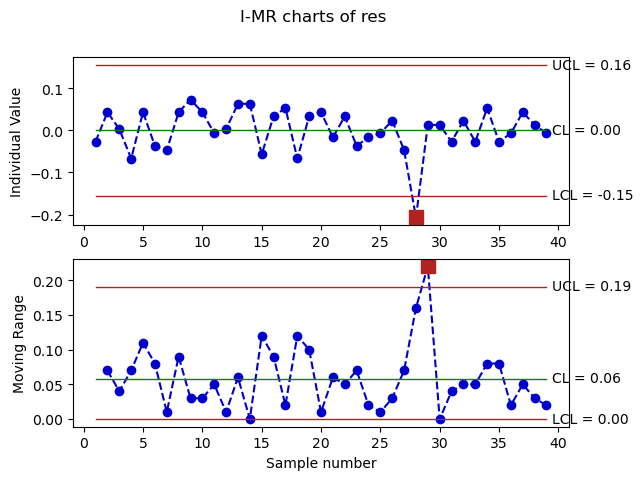

In [9]:
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(results.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

> ## Point 2

In [10]:
df['dummy']=np.zeros(40)
df['dummy'][28:]=1

c:\Users\Salam\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
import statsmodels.api as sm

x = df[['lag1','operation', 'dummy']][1:]
x = sm.add_constant(x) 
y = df['Xbar'][1:]
model = sm.OLS(y, x).fit()

qda.summary(model)

REGRESSION EQUATION
-------------------
Xbar =  + 1.916 const + 0.407 lag1 + 0.005 operation -0.211 dummy

COEFFICIENTS
------------
     Term    Coef  SE Coef  T-Value    P-Value
    const  1.9164   0.3603   5.3194 6.0992e-06
     lag1  0.4070   0.1112   3.6587 8.2737e-04
operation  0.0049   0.0013   3.8772 4.4474e-04
    dummy -0.2105   0.0416  -5.0668 1.3109e-05

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0393 0.8836     0.8736

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value    P-Value
Regression  3.0  0.4098  0.1366  88.5630 2.0507e-16
     const  1.0  0.0436  0.0436  28.2956 6.0992e-06
      lag1  1.0  0.0206  0.0206  13.3860 8.2737e-04
 operation  1.0  0.0232  0.0232  15.0323 4.4474e-04
     dummy  1.0  0.0396  0.0396  25.6726 1.3109e-05
     Error 35.0  0.0540  0.0015      NaN        NaN
     Total 38.0  0.4638     NaN      NaN        NaN


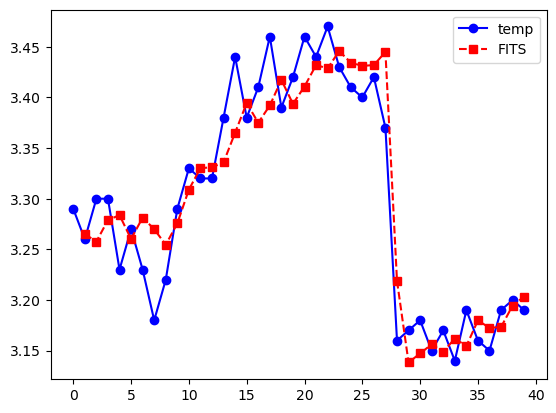

In [22]:
plt.plot(df['Xbar'], color='b', linestyle='-', marker='o', label='temp')
plt.plot(model.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

Shapiro-Wilk test p-value on the residuals = 0.860


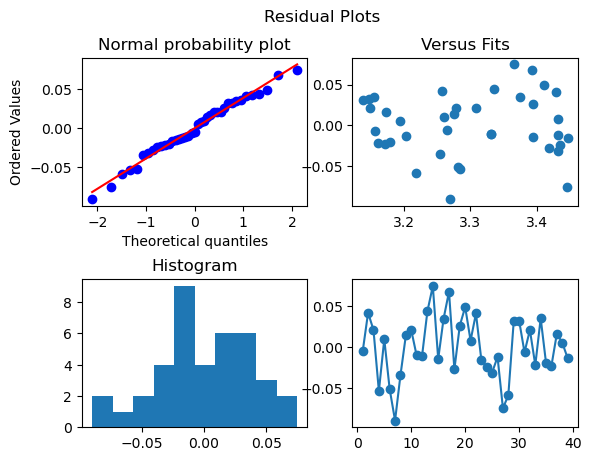

In [23]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.868


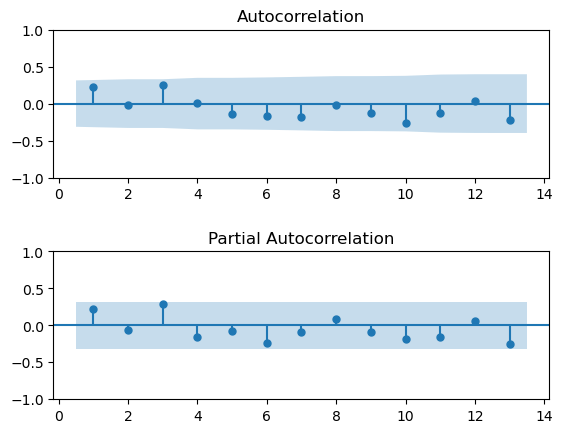

In [24]:
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

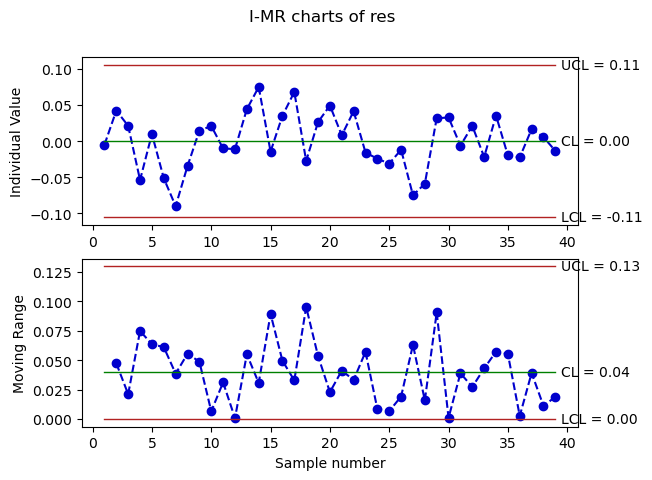

In [25]:
df_SCC = pd.DataFrame({'res': model.resid})
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res')

>## point 3

equality of vairance

In [29]:
var_1=df['Xbar'][0:28].var()
var_2=df['Xbar'][28:].var()

CL = 0.95       # Confidence level
alpha = 1 - CL  # Significance level

# Test the equality of variances
# F-test
F0 = var_1/var_2
df1 = len(df['Xbar'][0:28]) - 1 # degrees of freedom for supplier 1
df2 = len(df['Xbar'][28:]) - 1 # degrees of freedom for supplier 2
CI = [F0 * stats.f.ppf(alpha/2, df2, df1), F0 * stats.f.ppf(1-alpha/2, df2, df1)]
print('Confidence interval on the ratio of variances (CL = %.2f): [%.3f, %.3f]' % (CL, CI[0], CI[1]))

Confidence interval on the ratio of variances (CL = 0.95): [5.957, 47.062]


In [30]:
t0, p_value_t0 = stats.ttest_ind(df['Xbar'][0:28], df['Xbar'][28:], equal_var=False)
print('t-test: t0 = %.3f' % t0)
print('p-value for t-test: %.3f' % p_value_t0)

t-test: t0 = 10.757
p-value for t-test: 0.000


Reject. so mean is not constant

>## Point 4

In [31]:
print(model.params)

const        1.9164
lag1         0.4070
operation    0.0049
dummy       -0.2105
dtype: float64


In [32]:
data_predict = pd.DataFrame({'const': [1],'lag1': [df['Xbar'].iat[-1]], 'operation': [41], 'dummy':[1] })

In [33]:
#predict the next value
prediction = model.predict(data_predict)
print('The predicted value is %.3f.' % (prediction[0]))

The predicted value is 3.204.


In [34]:
# Compute the fit, confidence intervals and prediction intervals
prediction_summary = model.get_prediction(data_predict).summary_frame(alpha=0.05)
print(prediction_summary)

     mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  3.2043   0.0138         3.1762         3.2323        3.1197        3.2888
